In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import siglib

Define Constants
---

In [2]:
from siglib import data_m

results = []
min_depth = 100; clonality = (0, 0.4); notation = 'pyrimidine'

EG10gff_file = '/home/clint/essigmann_analysis/AFB1/data/EG10_corrected.gff'
EG10fasta_file = '/home/clint/essigmann_analysis/AFB1/data/EG10_corrected.fasta'
merfile = '/home/clint/essigmann_analysis/AFB1/data/EG10_slice_counts.jf'

Read in Trinucleotide Frequencies of Reference Genome
---

In [3]:
from jellywrap import Jellyfish, dna_notation

j = Jellyfish()
_ = j.read_mer_file(merfile)

Parse all Files and Plot Mutations *per* Genomic Position
---

Sample: 1642
Found 148 Mutations
Sample: 1643
Found 98 Mutations
Sample: 1644
Found 192 Mutations
Sample: 8114
Found 366 Mutations
Sample: 1639
Found 9 Mutations
Sample: 1640
Found 11 Mutations
Sample: 1641
Found 6 Mutations
Sample: 4508
Found 279 Mutations
Sample: 4509
Found 1134 Mutations
Sample: 8113
Found 227 Mutations


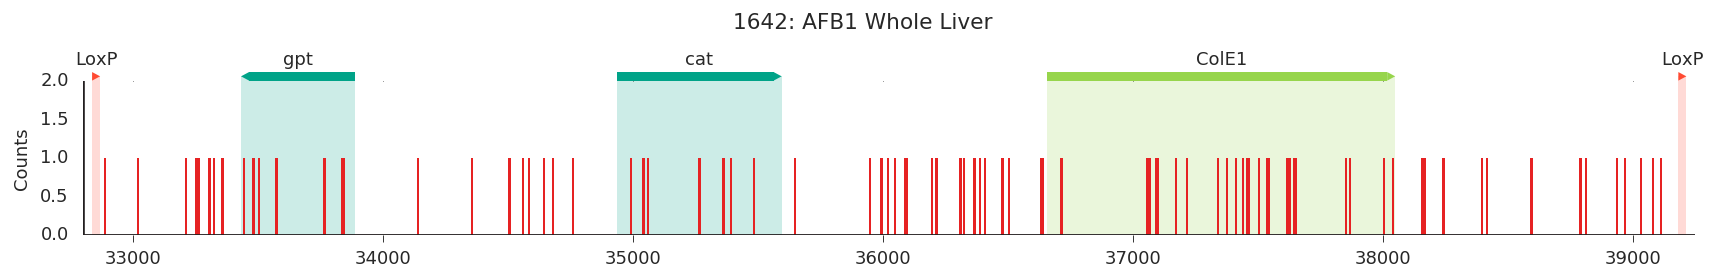

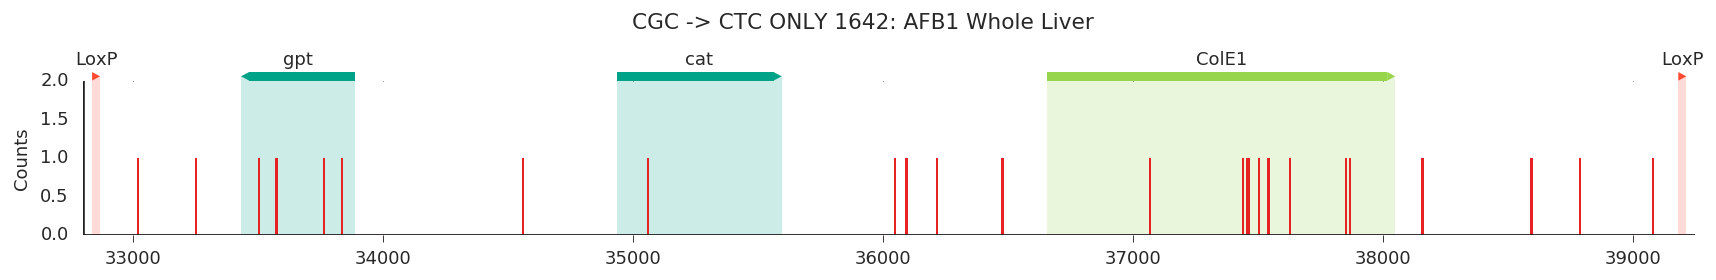

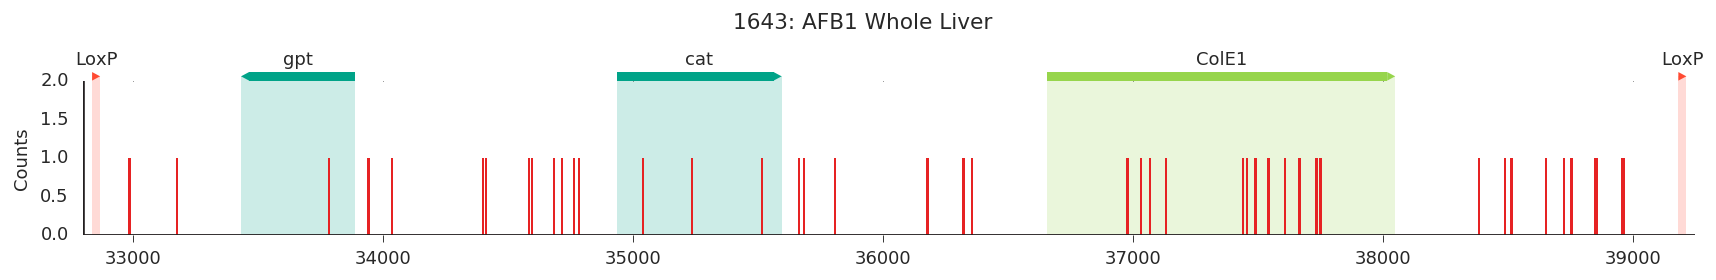

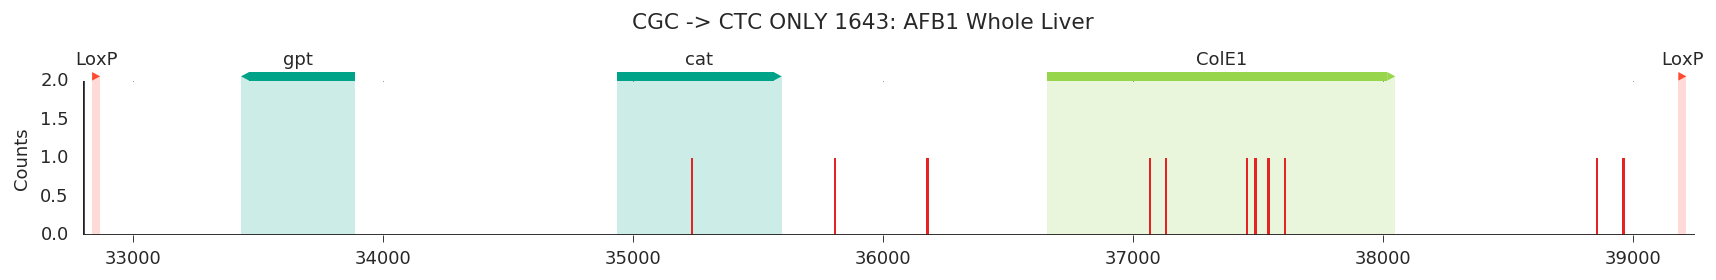

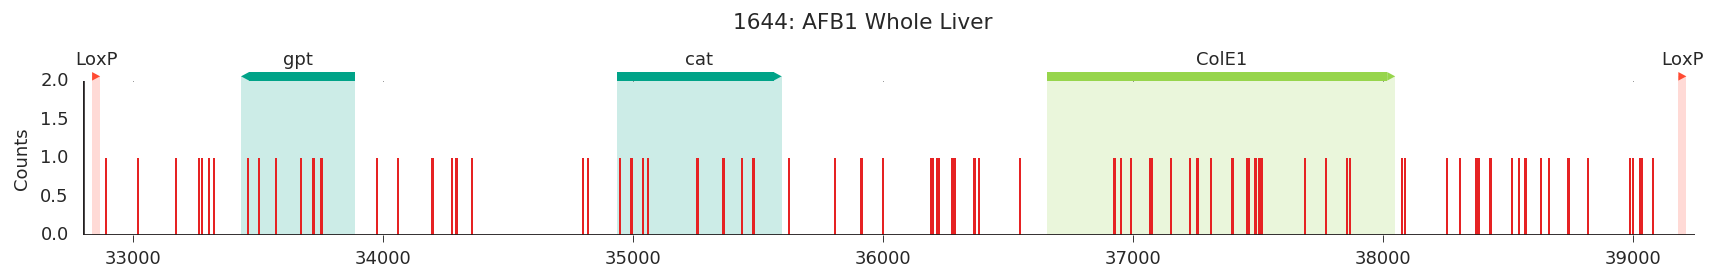

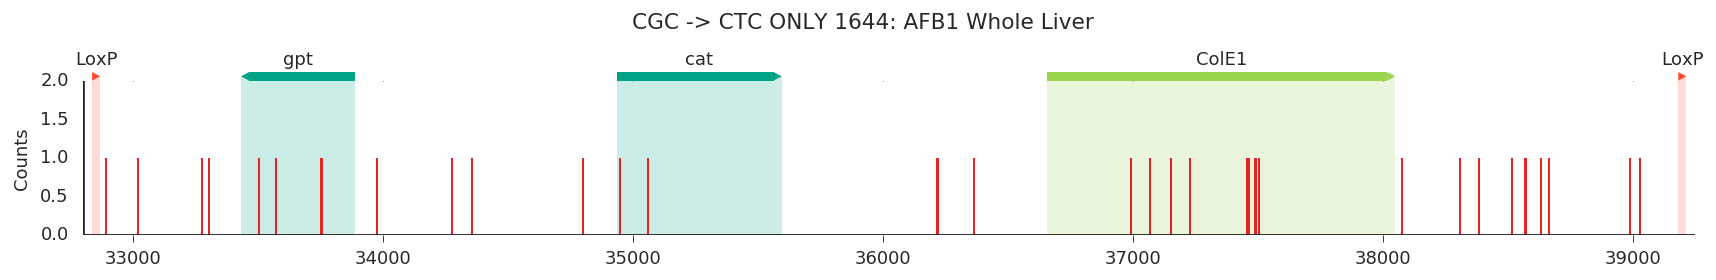

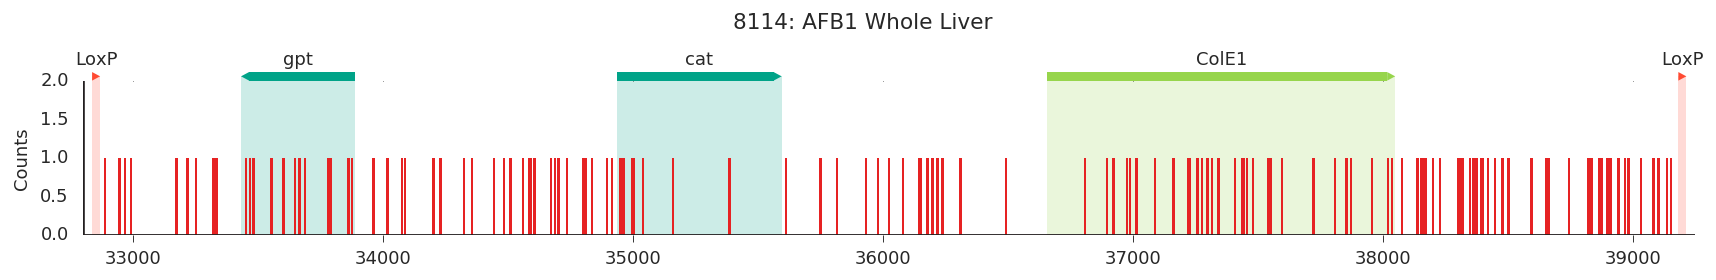

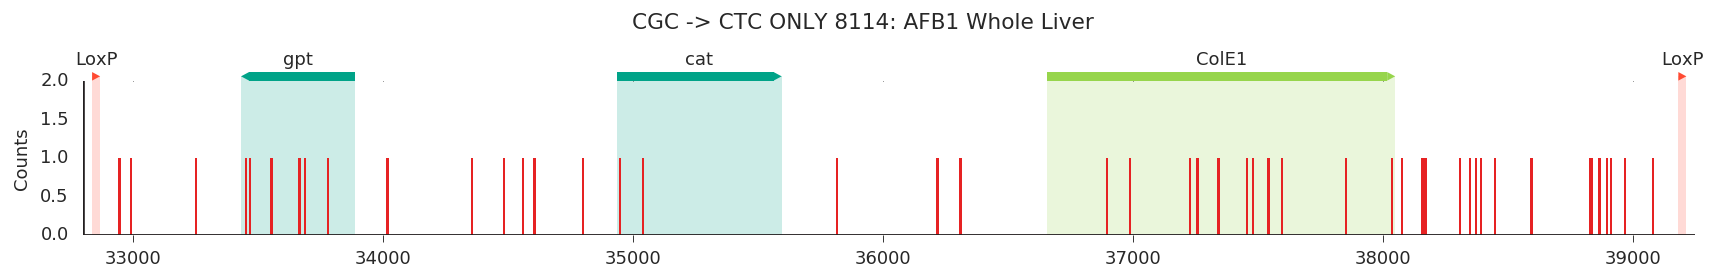

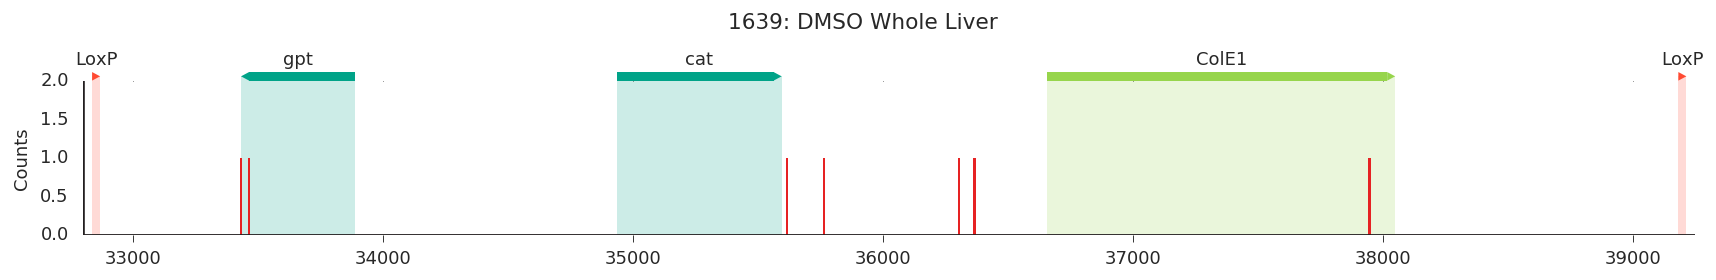

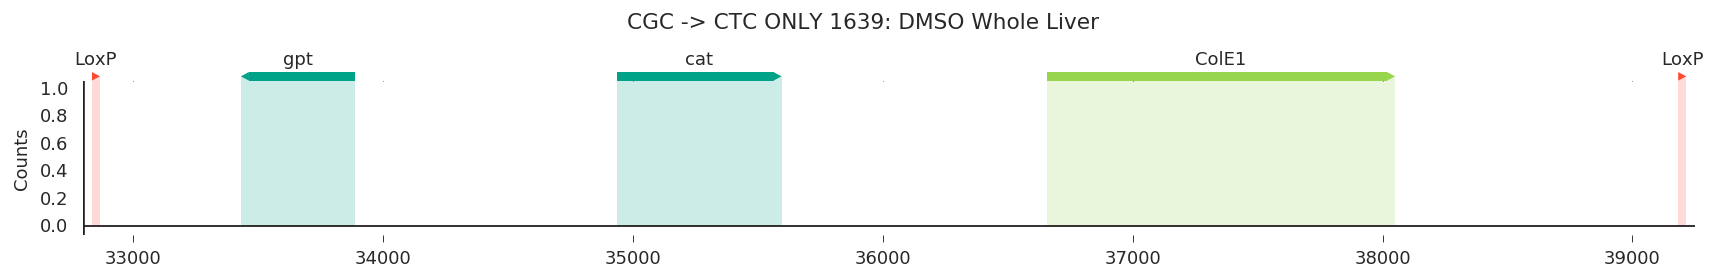

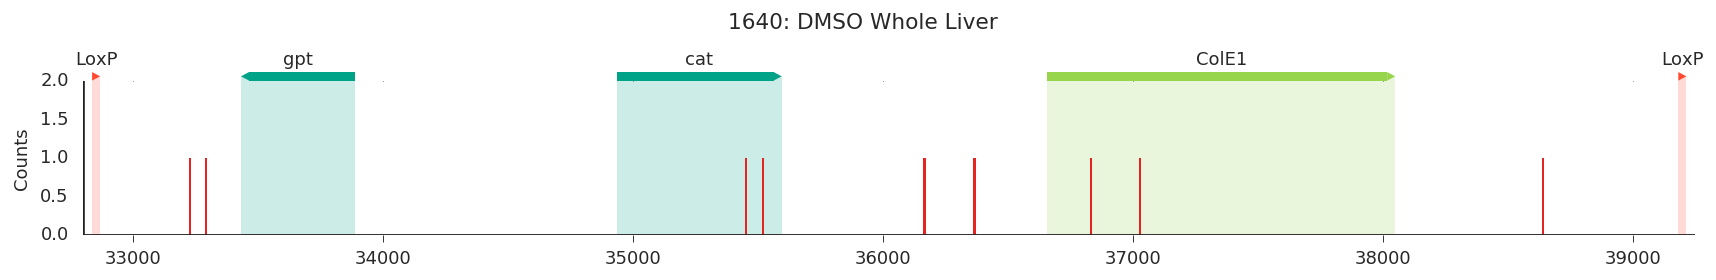

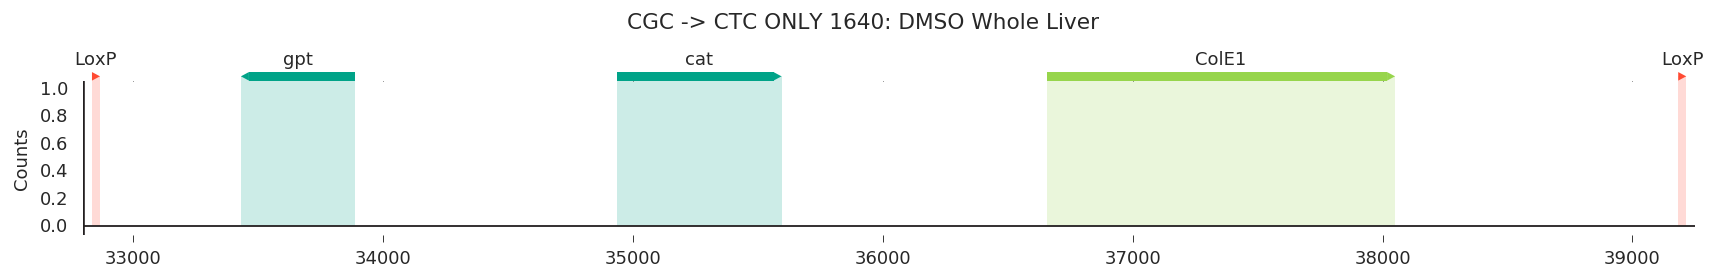

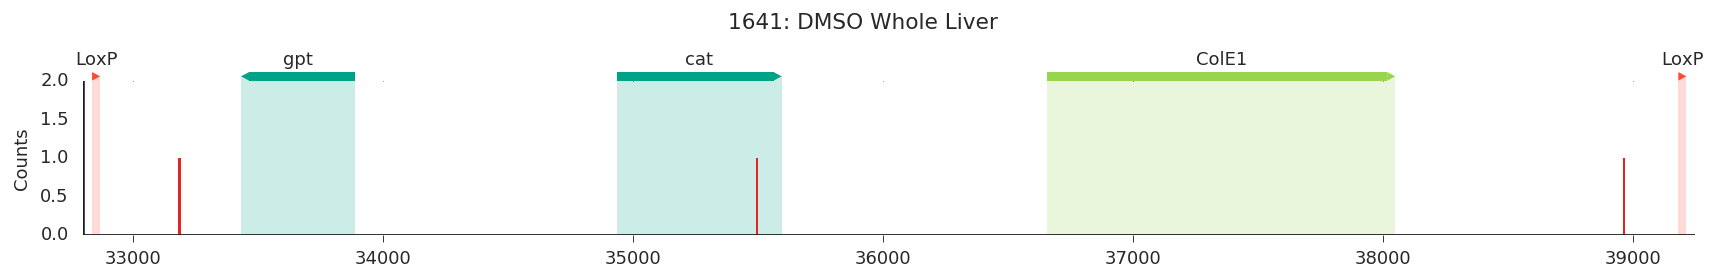

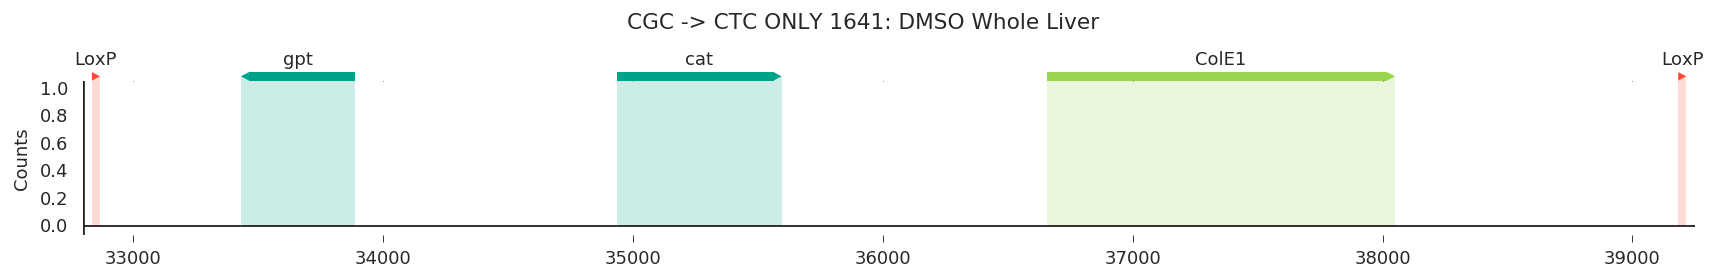

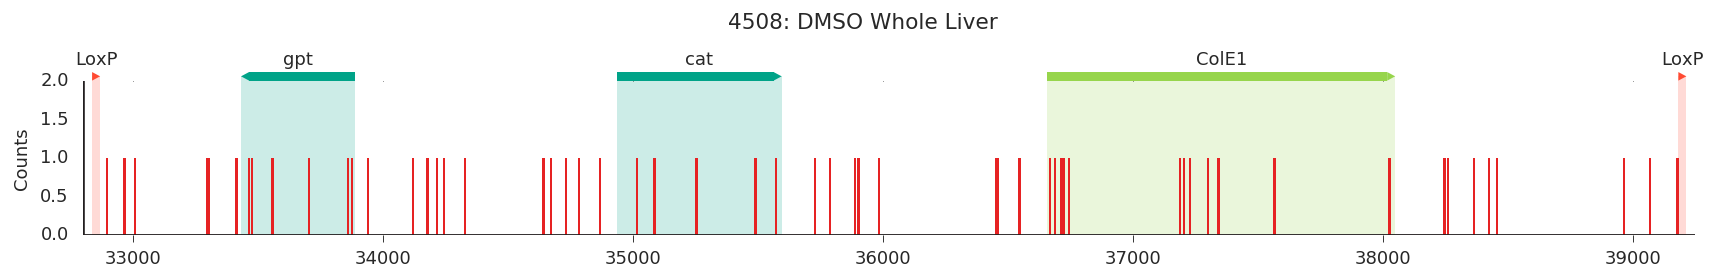

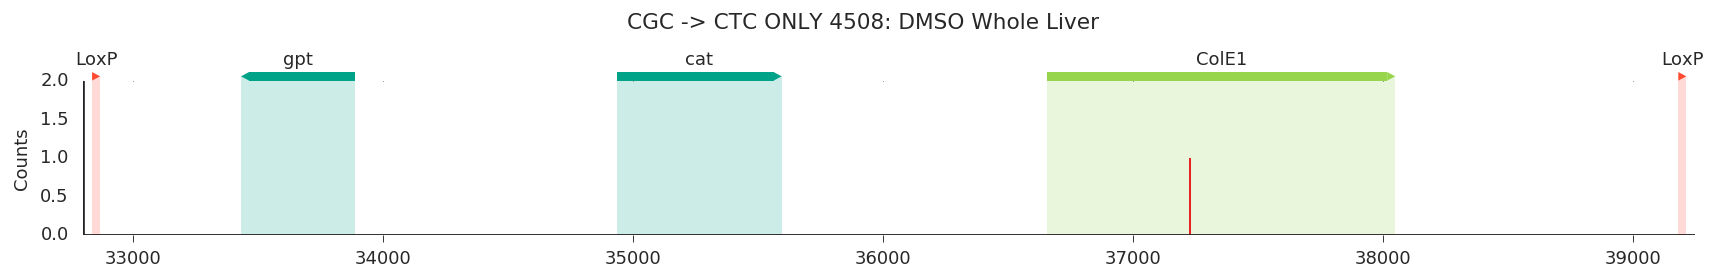

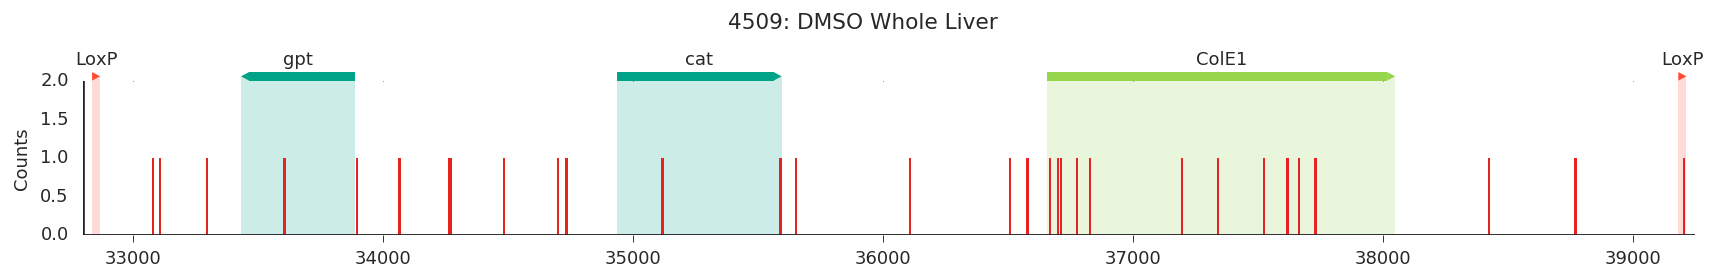

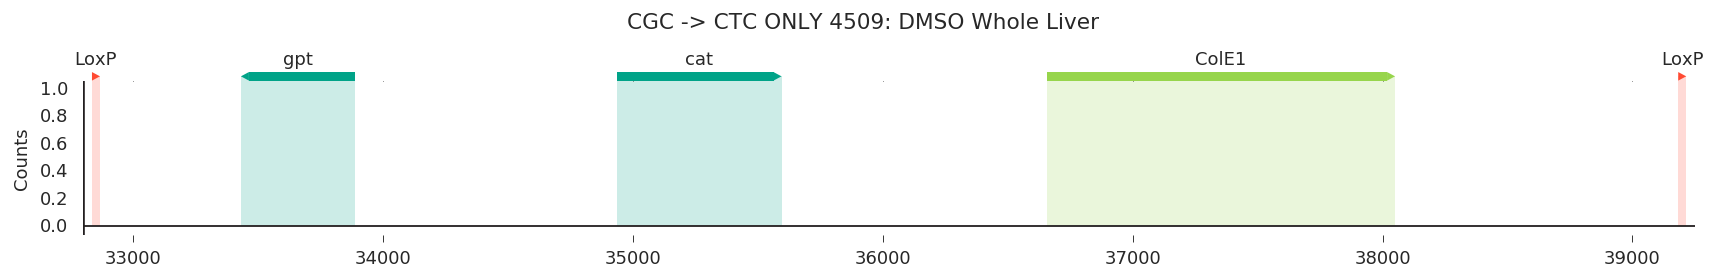

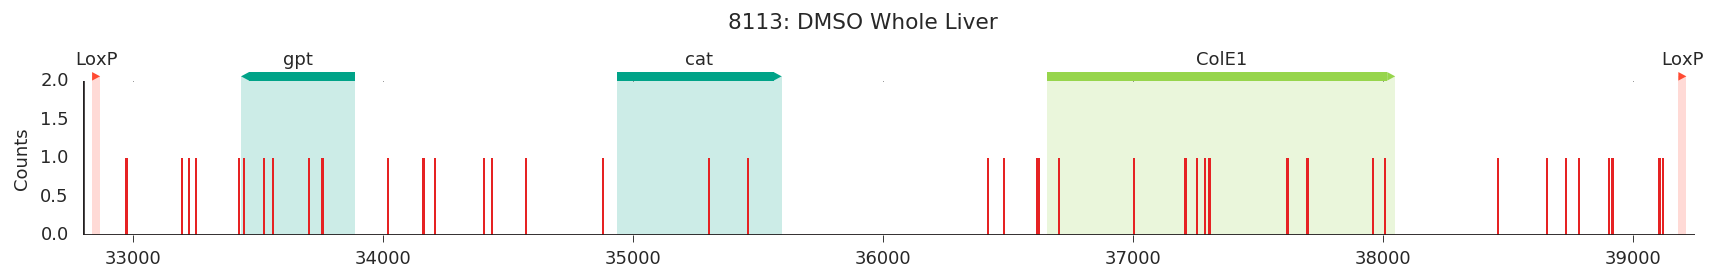

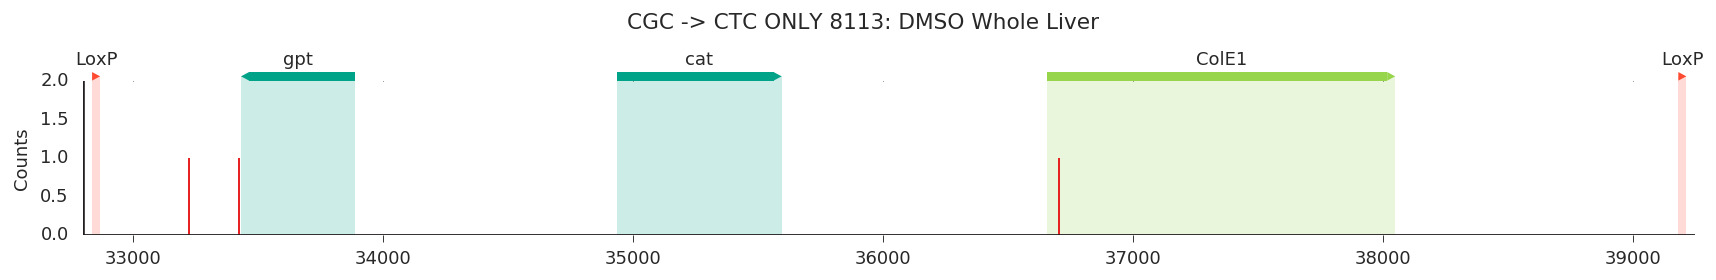

In [4]:
from siglib.mutpos import from_mutpos
from siglib.figures import variant_positions_plot

results = {}

for treatment in sorted(data_m[10].keys()):
    results[treatment] = {}
    for id, infile in sorted(data_m[10][treatment].items()):
        print('Sample: {}'.format(id))
        mutations = from_mutpos(infile, EG10fasta_file, clonality=clonality,
                                notation=notation, min_depth=min_depth, verbose=True)
        results[treatment][id] = mutations
        gff, ax = variant_positions_plot(positions=[m.position for m in sorted(set(mutations))],
                                         heights=[1 for m in sorted(set(mutations))],
                                         gff_file=EG10gff_file,
                                         title='{}: {}'.format(id, treatment),
                                         varplot_kwds={'xlabel': '', 'ylabel': 'Counts'})
        gff, ax = variant_positions_plot(positions=[m.position for m in sorted(set(mutations)) if m.context == 'GCG' and m.substitution[2] == 'A'],
                                 heights=[1 for m in sorted(set(mutations)) if m.context == 'GCG' and m.substitution[2] == 'A'],
                                 gff_file=EG10gff_file,
                                 title='CGC -> CTC ONLY {}: {}'.format(id, treatment),
                                 varplot_kwds={'xlabel': '', 'ylabel': 'Counts'})

Visualize Spectrum of Mutations in 3-mer Contexts
---

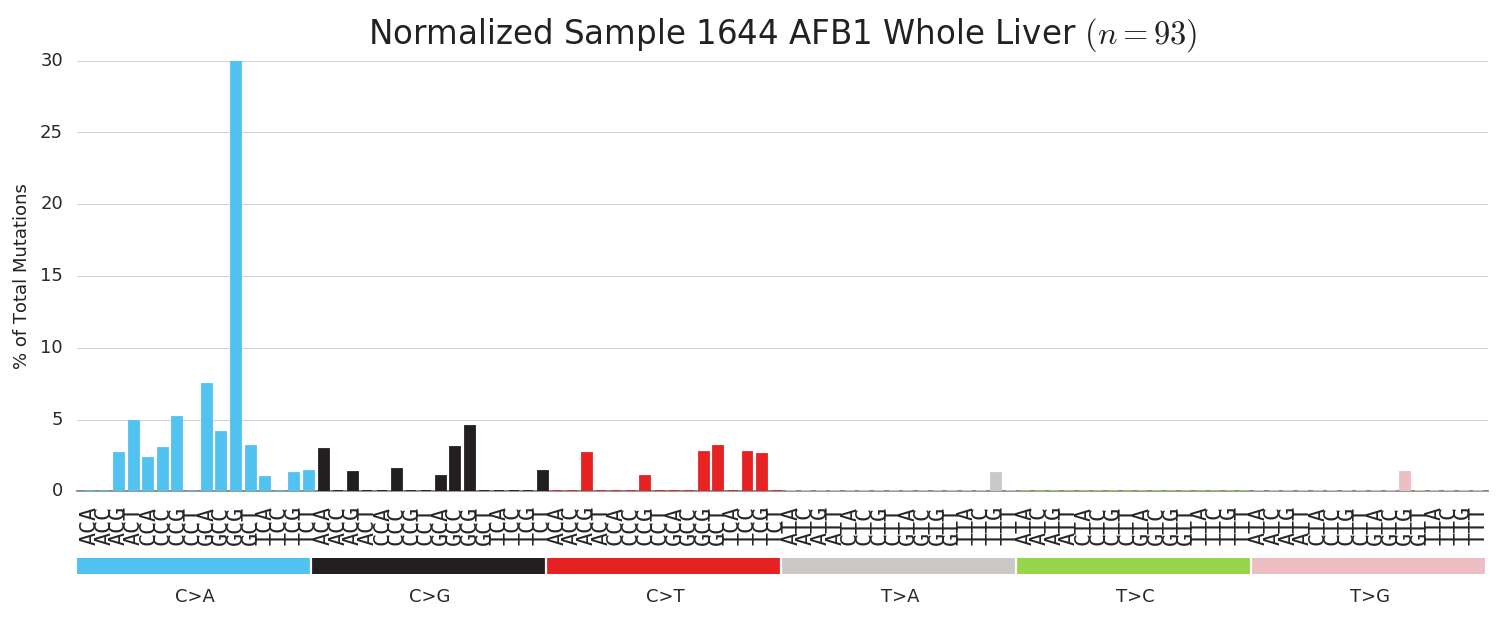

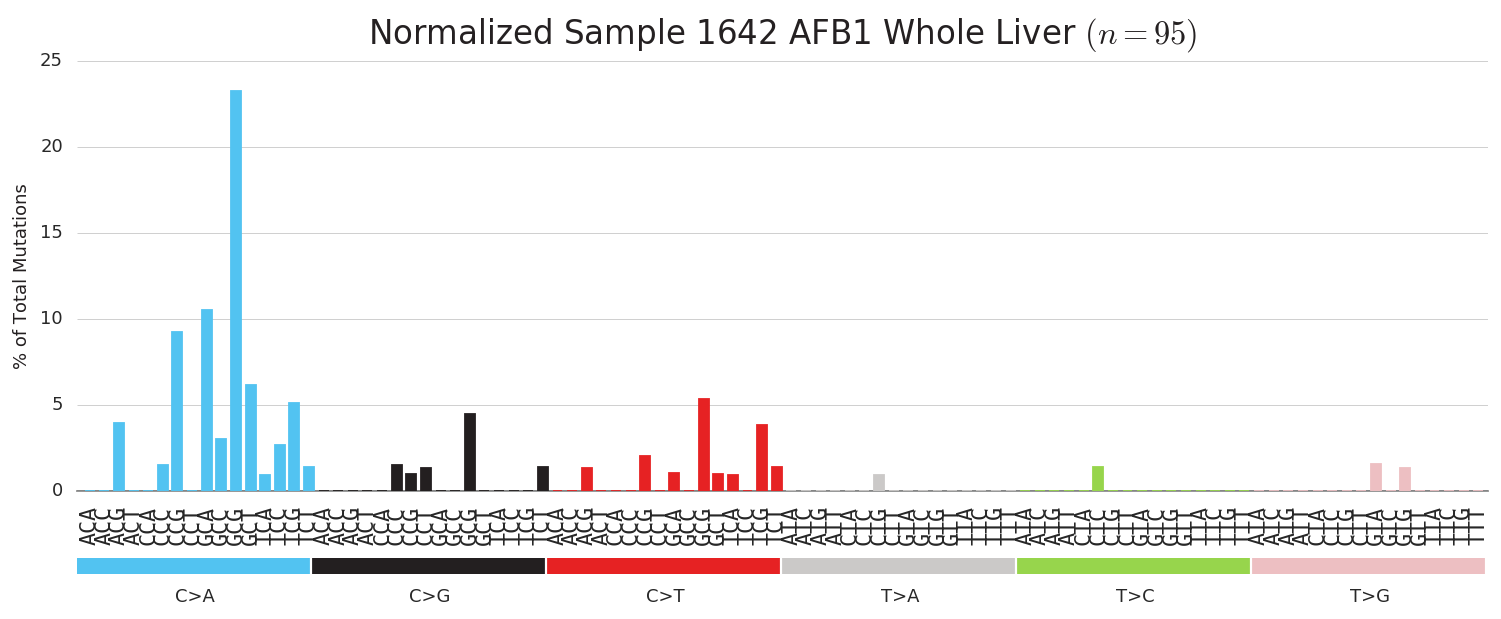

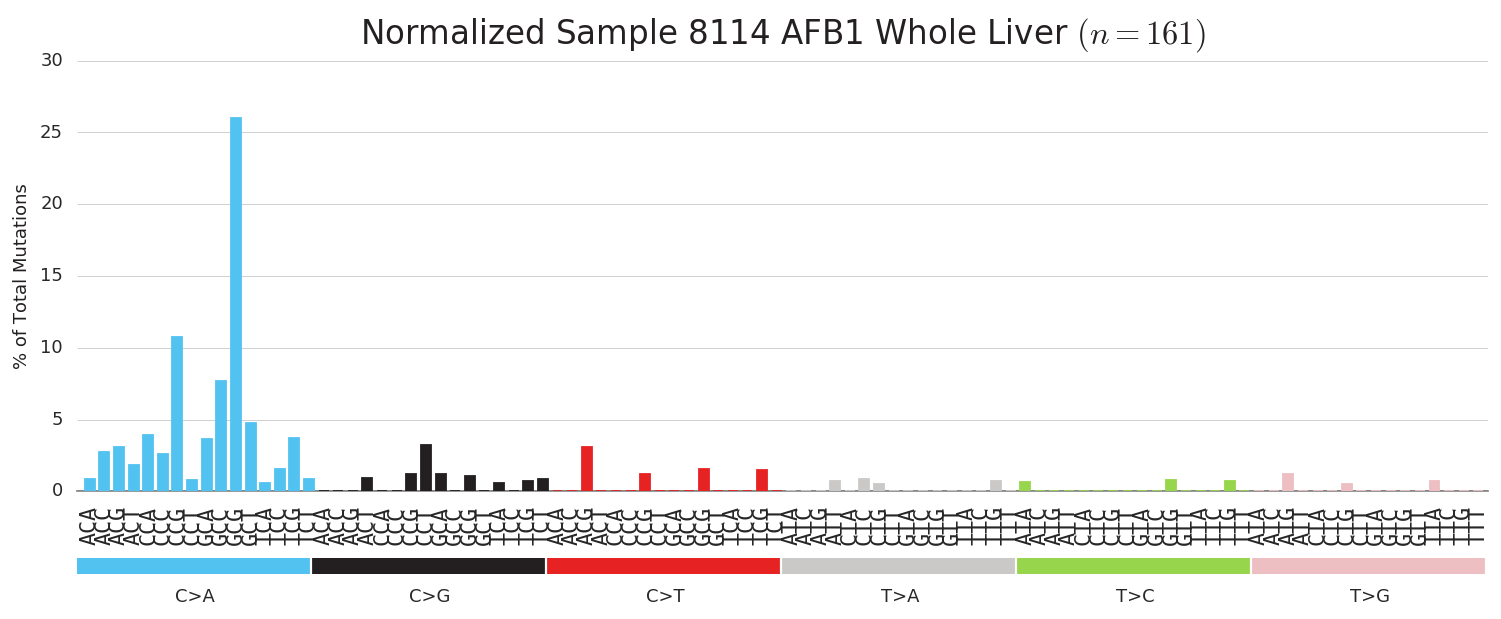

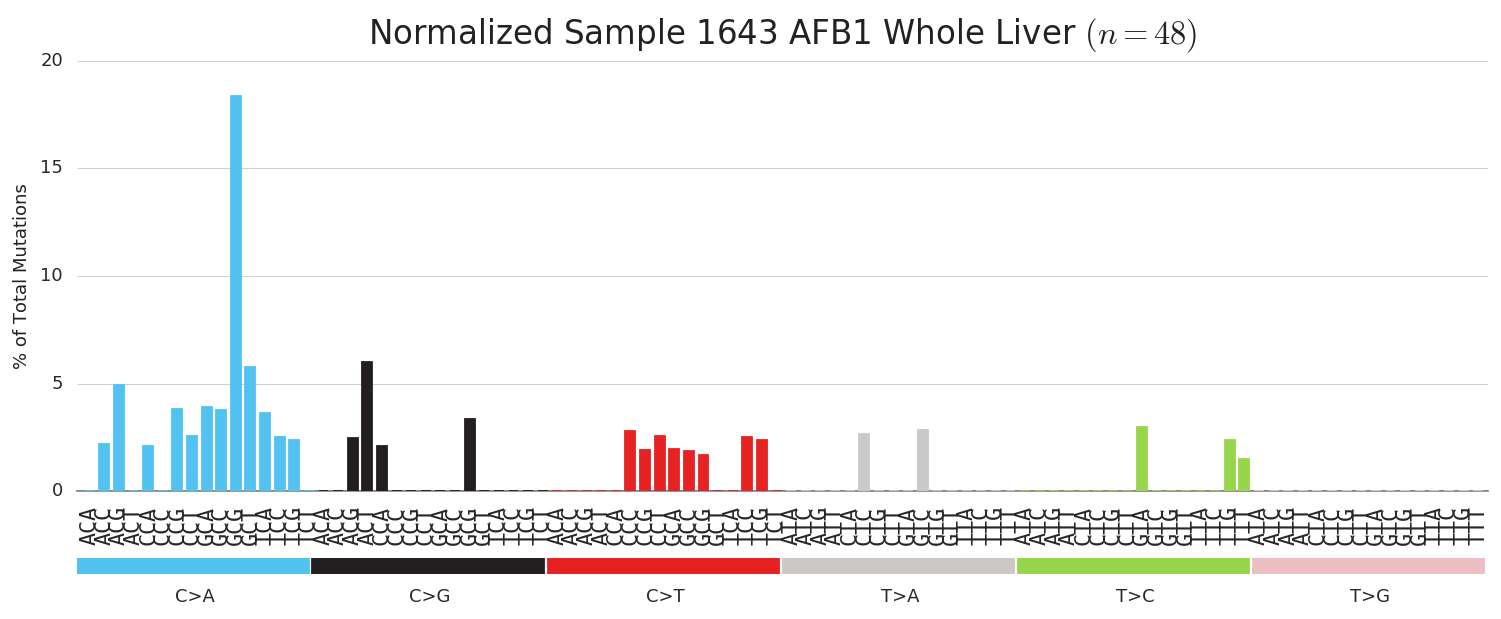

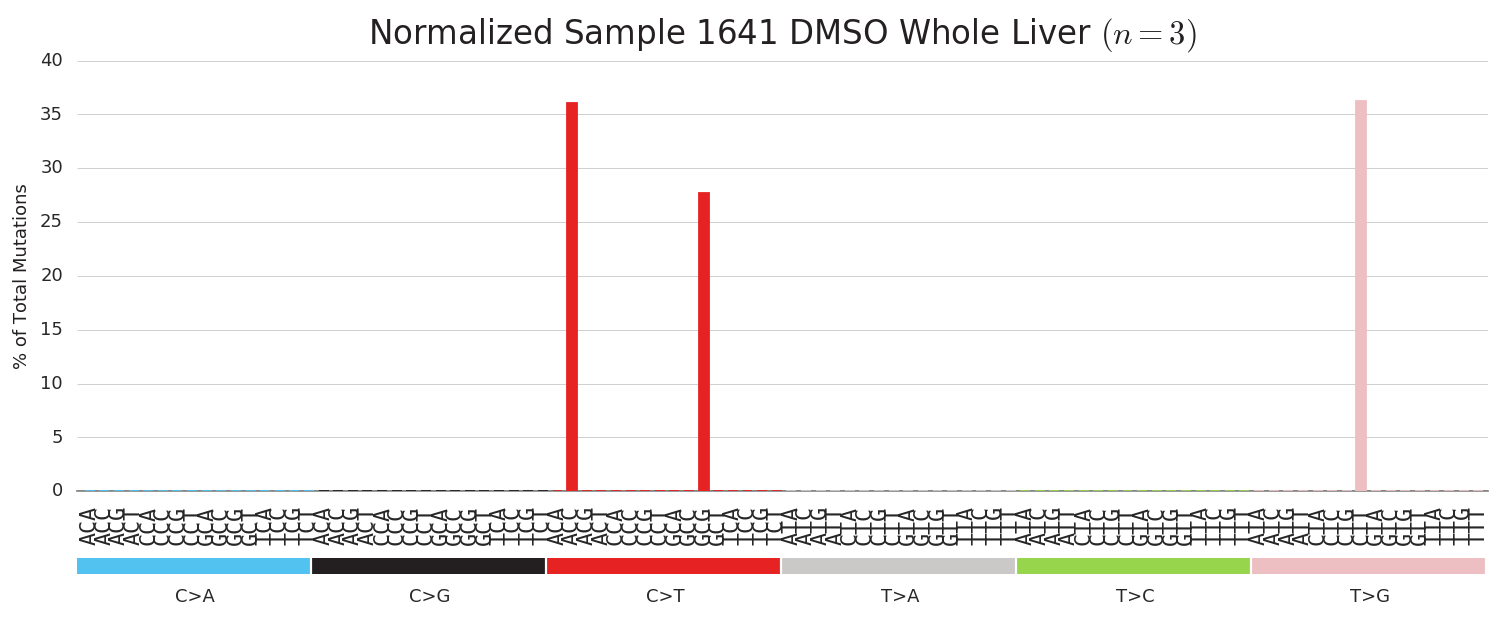

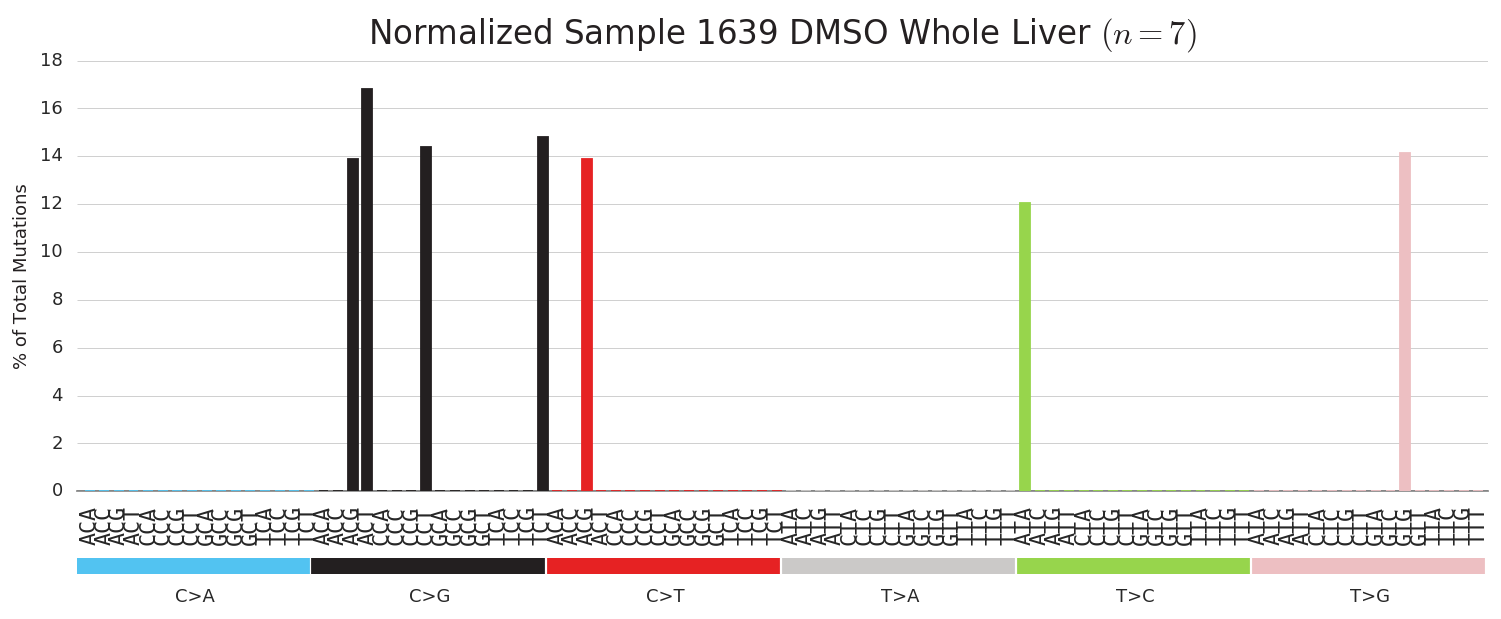

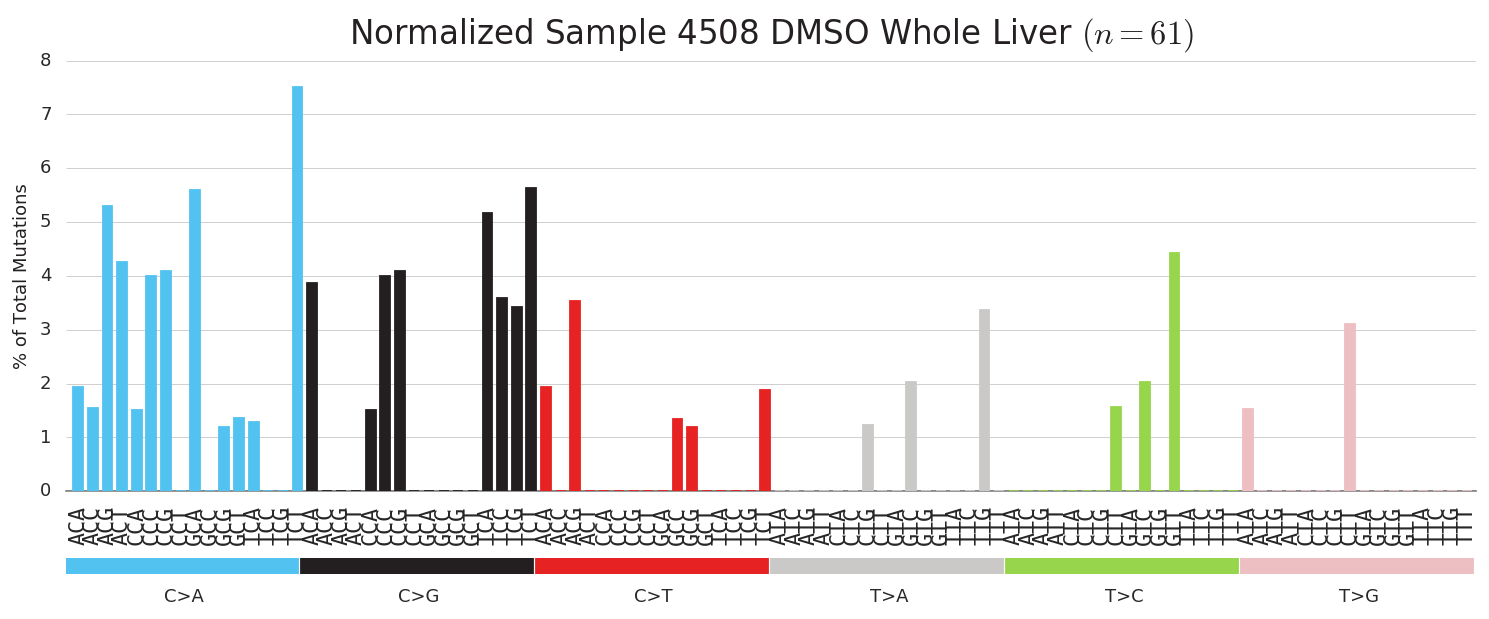

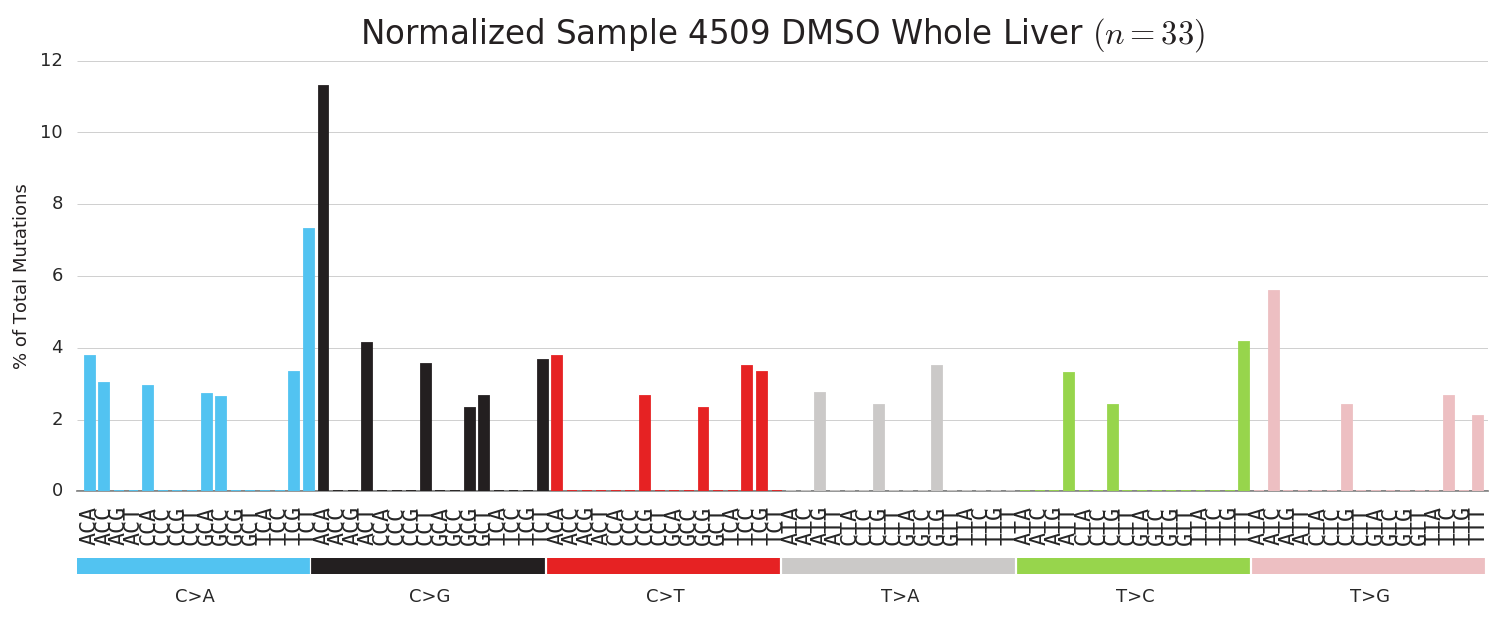

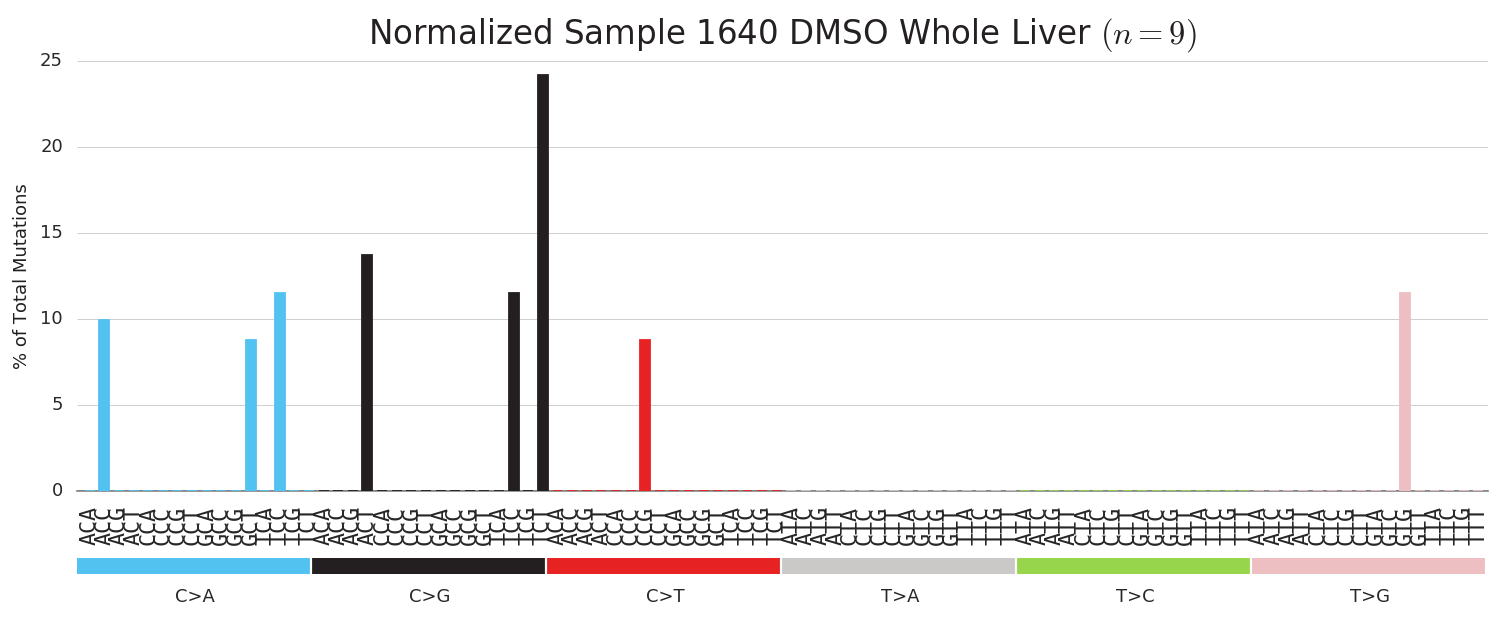

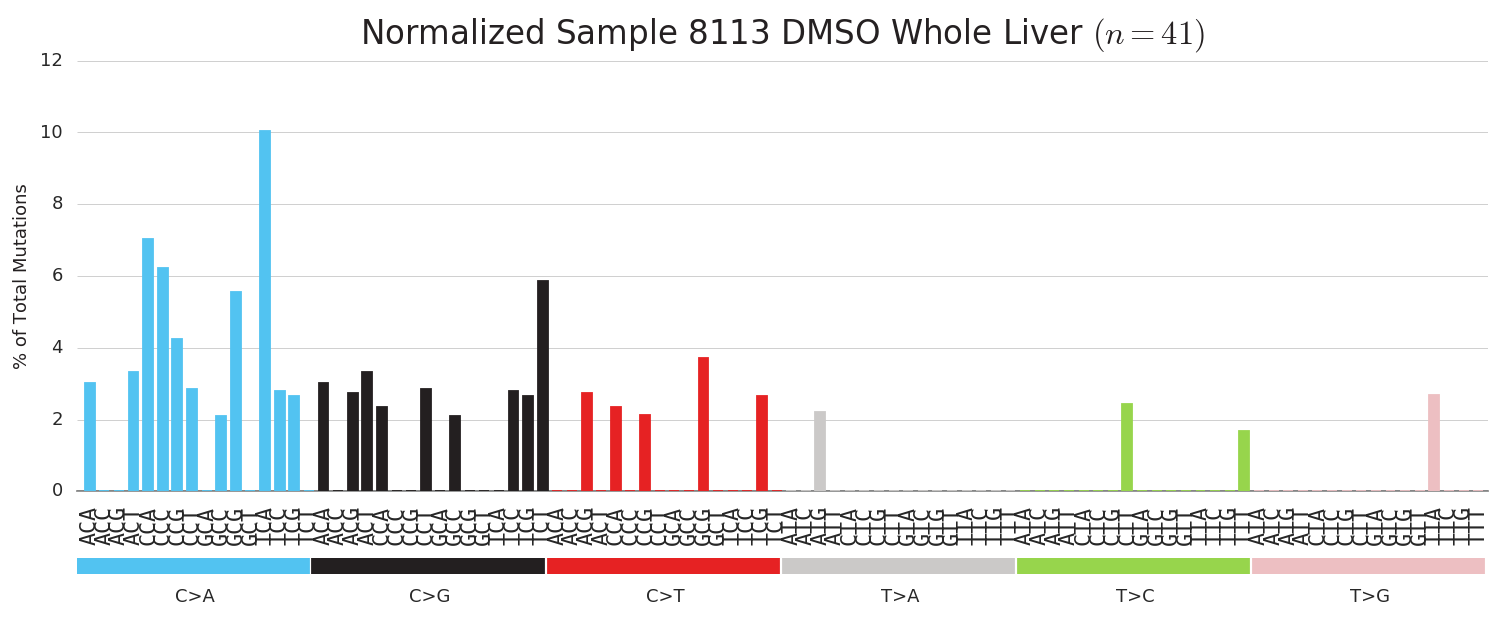

In [5]:
from siglib.utils import Spectrum
from siglib.figures import spectrum_map

for treatment in results:
    for id, mutations in results[treatment].items():
        spectrum = Spectrum(notation=notation, kmer=3)
        for mutation in set(mutations):
            spectrum[str(mutation.substitution), str(mutation.context)] += 1
        title = 'Normalized Sample {} {} $(n={})$\n\n'.format(id, treatment, spectrum.variant_total)
        spectrum_map(x=1, y=1,
                     heights=[[x * 100 for x in spectrum.normalized_proportion(j.normal())]],
                     xlabels=[spectrum.contexts],
                     labels=sorted(set(spectrum.sub_types)),
                     titles=[title])

AFB1 Whole Liver odict_values([1, 5, 11, 5, 9, 6, 34, 2, 25, 22, 120, 20, 5, 5, 11, 3, 2, 0, 2, 3, 1, 2, 3, 5, 3, 3, 14, 0, 1, 0, 1, 3, 0, 0, 7, 0, 0, 1, 6, 1, 2, 1, 13, 4, 1, 3, 8, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0])
DMSO Whole Liver odict_values([3, 3, 3, 3, 5, 4, 5, 1, 5, 2, 4, 2, 6, 2, 2, 6, 6, 0, 2, 4, 2, 2, 3, 3, 0, 1, 1, 1, 4, 4, 3, 9, 2, 1, 4, 0, 1, 0, 3, 0, 0, 1, 5, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 3, 0, 0, 0, 3, 1, 2, 0, 0, 0, 0, 1, 3, 0, 0, 2, 0, 1, 1, 0, 1])


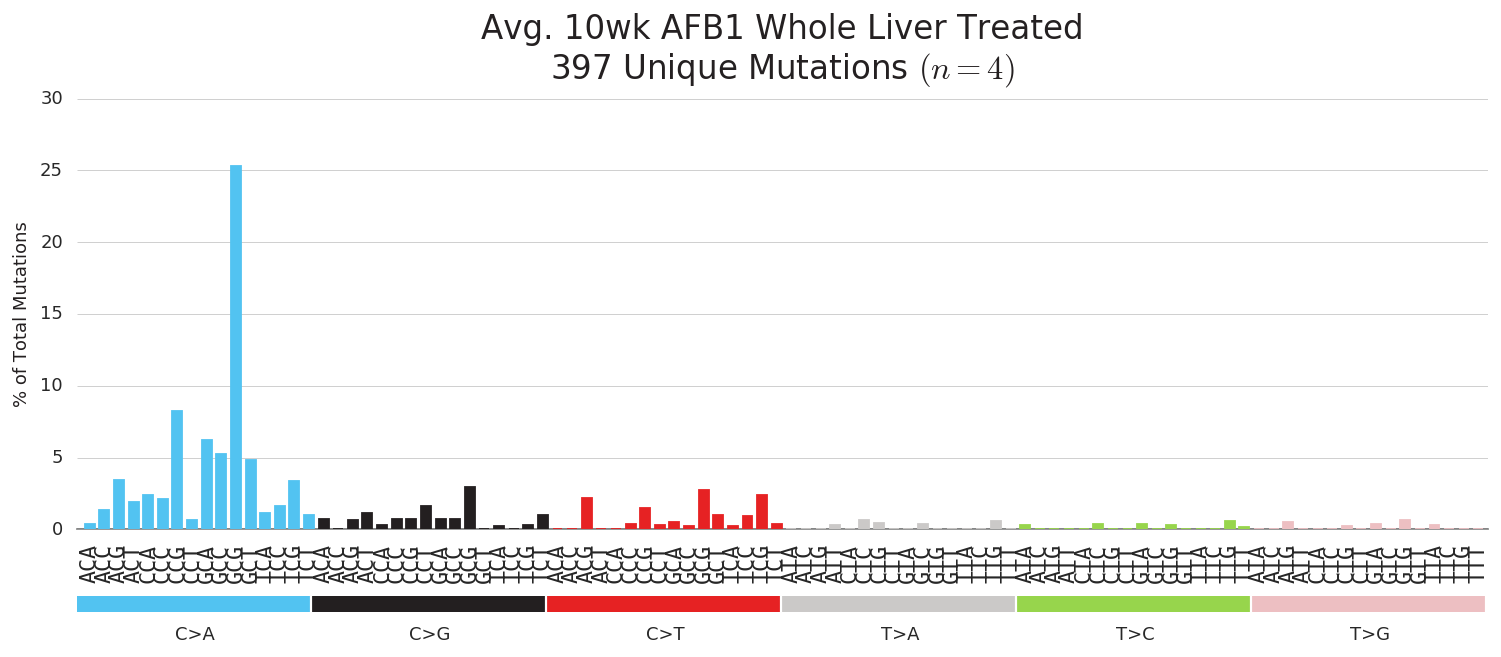

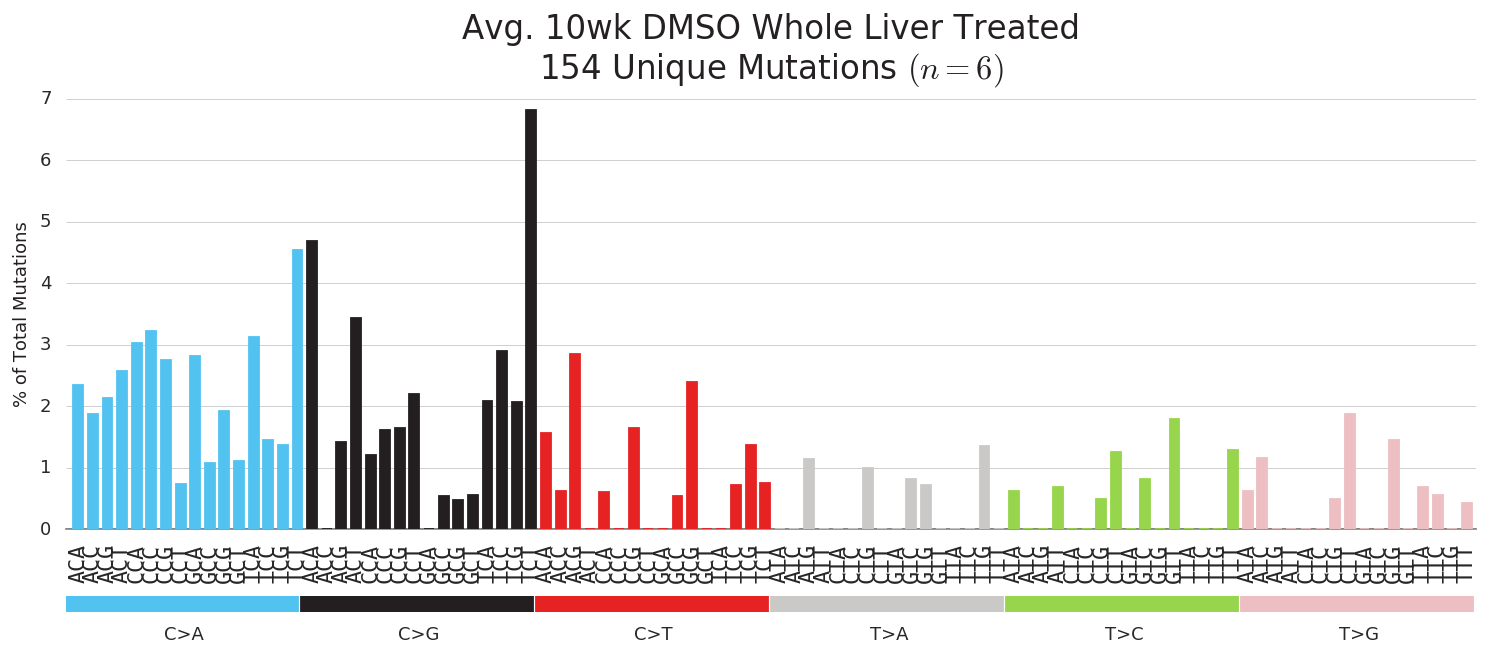

In [6]:
import matplotlib.pyplot as plt
from siglib.motifs import genome_browser

class Gene(object):
    def __init__(self, start, end, name):
        self.start = start
        self.end = end
        self.name = name


filenames = {
    'AFB1 Whole Liver': 'A10',
    'DMSO Whole Liver': 'D10',
}

for treatment in results.keys():
    outfile = filenames[treatment]
    full_sum = Spectrum(notation=notation)
    samples = 0
    for id, mutations in results[treatment].items():
        samples += 1
        for mutation in mutations:
            mutation.sample = treatment
        for mutation in set(mutations):
            full_sum[str(mutation.substitution), str(mutation.context)] += 1
    print(treatment, full_sum.values())
    title = 'Avg. 10wk {} Treated\n{} Unique Mutations $(n={})$\n\n'.format(treatment, full_sum.variant_total, samples)
    spectrum_map(x=1, y=1,
                 heights=[[x * 100 for x in full_sum.normalized_proportion(j.normal())]],
                 xlabels=[full_sum.contexts],
                 labels=sorted(set(full_sum.sub_types)),
                 titles=[title])
    plt.savefig('{}.pdf'.format(outfile))

fig = plt.figure(figsize=(20, 6), facecolor='white')
fig.suptitle('Lambda Interval')

from matplotlib.gridspec import GridSpec
from siglib.motifs import smooth_plot

gs = GridSpec(nrows=2,
              ncols=1,
              wspace=0,
              hspace=0.1)

for i, treatment in enumerate(results.keys()):
    mutations = []
    for x in results[treatment].values():
        for mutation in x:
            mutation.sample = treatment
            mutations.append(mutation)
        
    mutations = list(set(mutations))
    
    positions = [x.position for x in mutations]
    heights = [x.VAF for x in mutations]
    positions = sorted(positions)
    ax = smooth_plot(positions, heights,
                     ax=plt.subplot(gs[int(i)]),
                     x_lim=(min(positions), max(positions)),
                     color='#262626',
                     integer=False,
                     percent=True,
                     tick_thin=True,
                     annotation="Sample".format(treatment))
    ax.set_ylim(0, 0.02)

In [7]:
from pybedtools import BedTool
from siglib.motifs import Motif

for gene in BedTool('/home/clint/dcstools/ref/EG10_custom/EG10_corrected.bed'):
    if gene.name == 'EG10_custom':
        gene.name = 'Genomic Interval'
        break

motifs = []        

with open('/home/clint/dcstools/ref/EG10_custom/EG10_custom.gff', 'r') as infile:
    for line in infile:
        genome, t, feature, start, end, _, strand, _, *metadata = line.split()
        motif = Motif('T' * int(int(end) - int(start)), int(start), strand, feature)
        motifs.append(motif)

In [11]:
a_mut = []
d_mut = []
for treatment in results.keys():
    for name, ms in results[treatment].items():
        for m in ms:
            m.sample = treatment
            if treatment == 'DMSO Whole Liver':
                d_mut.append(m)
            else:
                a_mut.append(m)
                
a_mut = set(a_mut)
d_mut = set(d_mut)

mutations = list(a_mut) + list(d_mut)


/usr/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


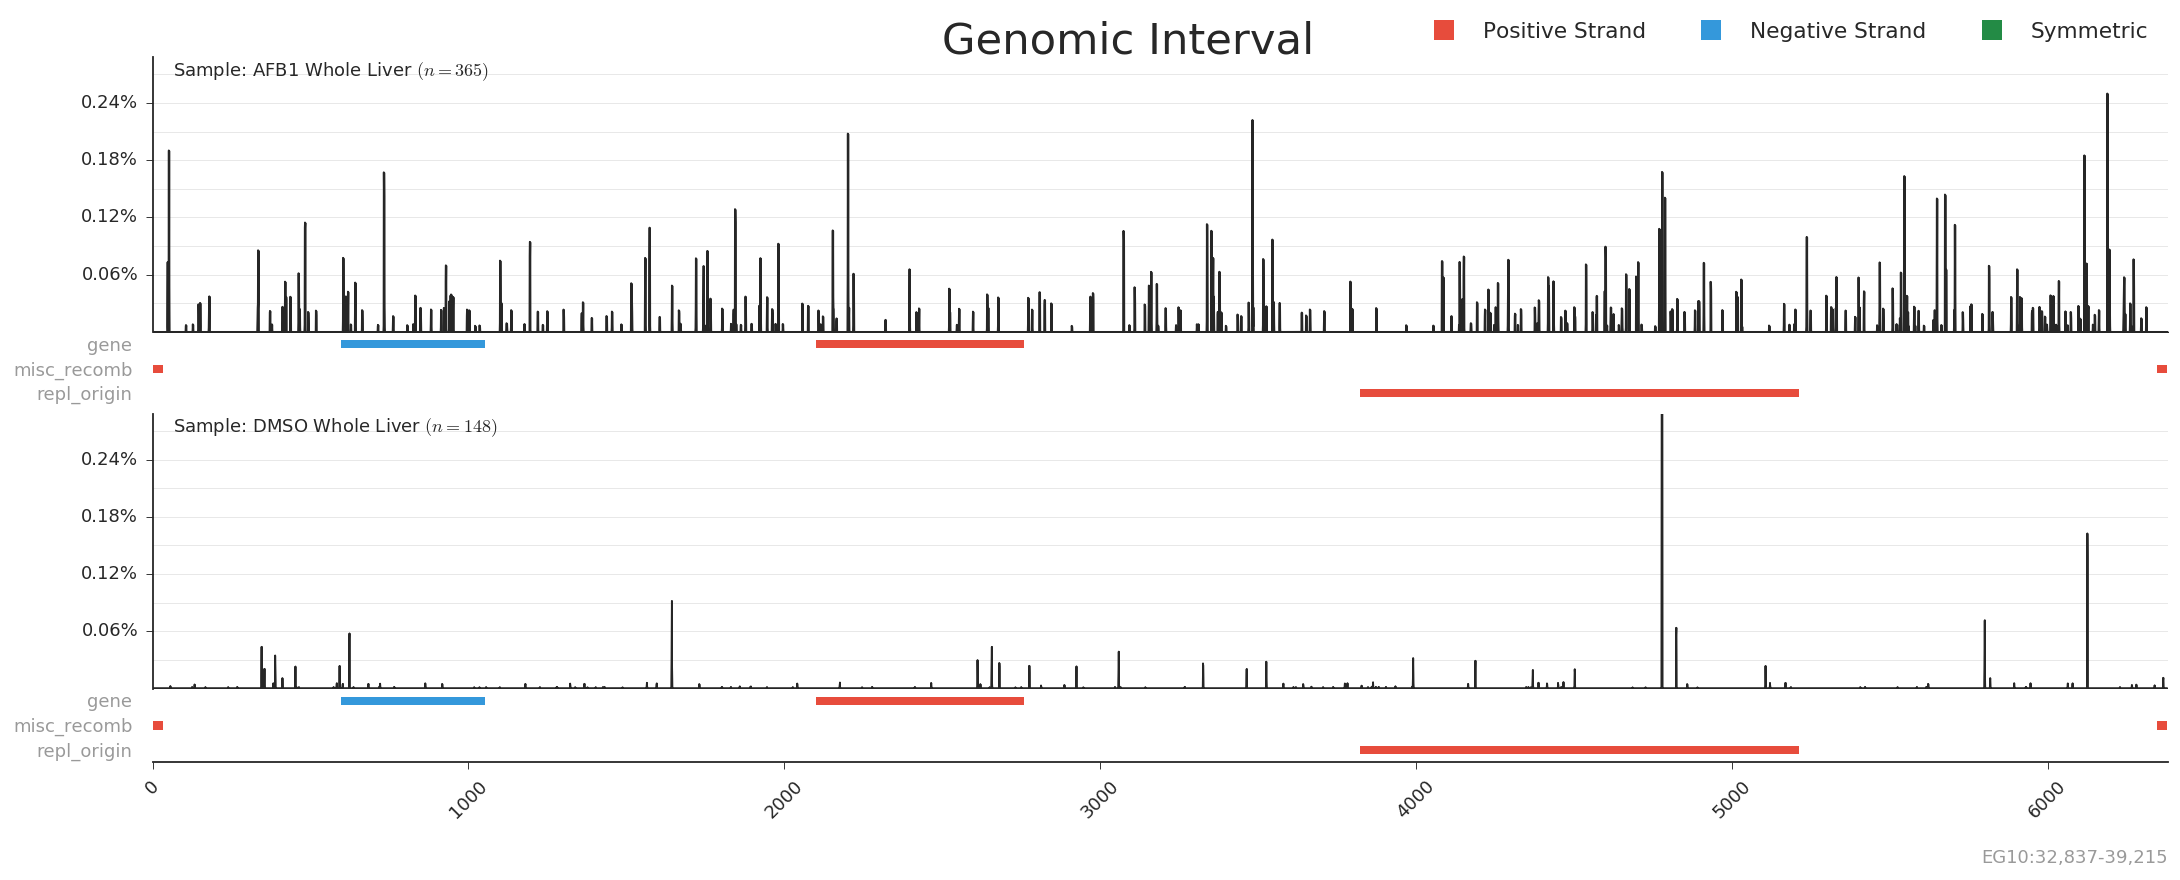

In [16]:
from siglib.motifs import genome_browser
genome_browser(mutations, motifs, gene, step=1000, background=None, y_max=0.0024)
plt.savefig('2.png', dpi=700)